# Project 4: Question Answering on Squad
## CS4740/5740 Fall 2020

### Project Submission Due: Monday, December 21, 11:59pm
Please submit a **pdf file** of this notebook on **Gradescope**, and **ipynb** on **CMS**. For instructions on generating pdf and ipynb files, please refer to the pinned Piazza post @695.



Name:
Anya Ji



Netid:
aj592


This assignment is to be done **on your own**, i.e., without any teammate.

# Notes

---

1. Please read through the entire notebook before you start coding. That might inform your code structure.
2. Google colab does **not** provide good synchronization; we do not recommend multiple people to work on the same notebook at the same time.




# Overview

---

In this project you will develop NLP models for question-answering tasks. Specifically, you will train models on the SQuAD 2.0 dataset which contains questions on text segments from Wikipedia. The dataset aims to measure the reading comprehension capabilities of machines. Some examples from the main paper are given below. For Project 4, the task is divided into two parts. First, you will decide on a model by yourself and train it on this task. Secondly, you will fine-tune a pretrained model. 




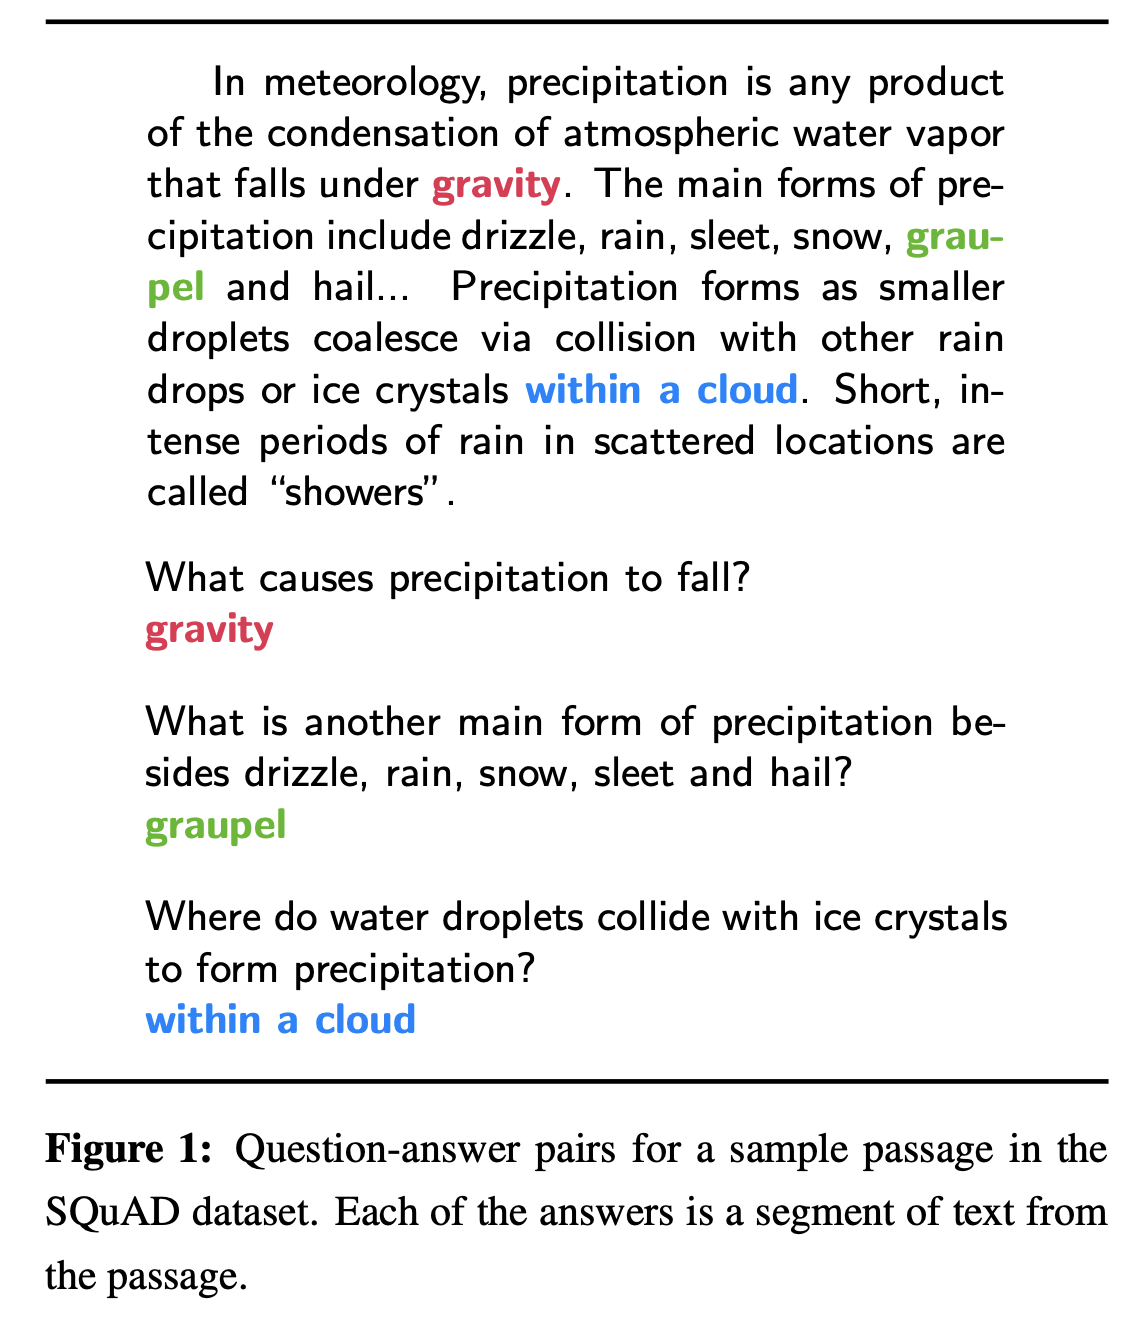

# Task and dataset

---

Obtain the data from [here](https://p4-squad-data.s3.us-east-2.amazonaws.com/train-v2.0.json). You also may consider doing so in a code block below.

```bash
!wget https://p4-squad-data.s3.us-east-2.amazonaws.com/train-v2.0.json
```

This gives you the dataset containing about 113,000 examples. You should split this into a **train** and **validation** dataset as in Project 2.


In [ ]:
import collections
import json
import string
import re

import numpy as np

In [ ]:
!wget https://p4-squad-data.s3.us-east-2.amazonaws.com/train-v2.0.json

In [ ]:
from collections import Counter

with open('train-v2.0.json') as file:
  data = json.load(file)

def mc(lst):
    data = Counter(lst)
    return data.most_common(5)

number of paragraphs/contexts:  19035
number of qas:  130319
number of unanswerable questions:  43498 ,  33.37809528925176 %


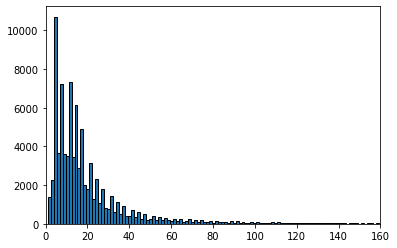

most occured span lengths:  [(4, 7089), (7, 3777), (12, 3753), (6, 3659), (5, 3623)]
mean length of span:  20.149168979855105
max span length:  239


In [ ]:
import matplotlib.pyplot as plt
size = 0
unans = []
pcount = 0
span_len = []
for d in data['data']:
  for p in d['paragraphs']:
    pcount+=1
    size+= len(p['qas'])
    for q in p['qas']:
      if q['is_impossible']:
        unans.append((q, p['context']))
      else:
        span_len.append(len(q['answers'][0]['text']))
print('number of paragraphs/contexts: ', pcount)
print('number of qas: ', size)
print('number of unanswerable questions: ', len(unans),', ', len(unans)/size*100, '%')
plt.hist(span_len, bins=len(set(span_len)), edgecolor = 'black')
plt.xlim(0,160)
plt.show()
print('most occured span lengths: ', mc(span_len))
print('mean length of span: ', sum(span_len)/len(span_len))
print('max span length: ', max(span_len))

In [ ]:
# training and validation
import random
paragraphs = []
for d in data['data']:
  for p in d['paragraphs']:
    paragraphs.append(p)
validation = [paragraphs.pop(random.randrange(len(paragraphs))) for _ in range(int(len(paragraphs)*0.1+1))]
train = paragraphs

def observe(s, train = True):
  print('training set' if train else 'validation set')
  print('number of paragraphs: ', len(s))
  size = 0
  unans = 0
  span_len = []

  for p in s:
    size+= len(p['qas'])
    for q in p['qas']:
      if q['is_impossible']:
        unans+=1
      else:
        span_len.append(len(q['answers'][0]['text']))

  print('number of qas: ', size)
  print('most occured span lengths: ', mc(span_len))
  print('mean length of span: ', sum(span_len)/len(span_len))
  print('number of unanswerable questions: ', unans,', ', unans/size*100, '%\n')

observe(train)
observe(validation, False)


training set
number of paragraphs:  17131
number of qas:  117303
most occured span lengths:  [(4, 6352), (7, 3417), (12, 3361), (6, 3280), (5, 3264)]
mean length of span:  20.20147517512911
number of unanswerable questions:  39075 ,  33.31116851231427 %

validation set
number of paragraphs:  1904
number of qas:  13016
most occured span lengths:  [(4, 737), (12, 392), (6, 379), (9, 375), (7, 360)]
mean length of span:  19.672989642732457
number of unanswerable questions:  4423 ,  33.98125384142593 %



### Q1: Initial data observations
What are your initial observations after you explore the dataset?

**Answer:**

The dataset contains 19035 paragraphs with 130319 questions and answers, about 33% of which are unanswerable (43498). Among the answerable questions, the mean length of answer spans is about 20 words, with lengths of 4-12 being the most common. The distribution of span lengths is shown above.

At a closer look, there are multiple types of unanswerable questions. For example:

1. Entity Swap: 

The context is about 'The Legend of Zelda: Twilight Princess', but the question asks about 'Legend of Zelda: Australia Twilight'.

>Q: 'What category of game is Legend of Zelda: Australia Twilight?',


>S: 'The Legend of Zelda: Twilight Princess (Japanese: ゼルダの伝説 トワイライトプリンセス, Hepburn: Zeruda no Densetsu: Towairaito Purinsesu?) is an action-adventure game developed and published by Nintendo...'


2. Mutual Exclusion:

'Both lives with a shrimp and cleans up ectoparasites on other fish' as in the question is mutually exclusive with the information in the context (either lives with shrimp or cleans up ectoparasites in other fish)

>Q: 'What is the species of goby that both lives with a shrimp and cleans up ectoparasites on other fish?'

>S: 'A further example is the goby fish, which sometimes lives together with a shrimp. ... Different species of gobies (Elacatinus spp.) also exhibit mutualistic behavior through cleaning up ectoparasites in other fish.'


3. Antonym:

'Unlimited' in questions vs. 'limited' in context.


>Q: 'What do many political scientists think is a factor in an unlimited degree in American exceptionalism?',

>S: 'Many political scientists believe that separation of powers is a decisive factor in what they see as a limited degree of American exceptionalism.'


Lastly, we devided the dataset into training (90%) and validation (10%) sets by randomly selecting on paragraphs. The percentage of unanswerable questions and the distribution and mean of span lengths in both sets are similar (around 33%).

The two metrics we will be using are **exact match** and **F1**. The exact match metric measures the percentage of predictions that match any one of the ground truth answers **exactly**. The F1 score is a looser metric, which measures the average overlap between the prediction and ground truth answer.

The F1 metric on answers is defined as:

$$F_1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

where $Precision$ is:
$$Precision = \frac{TP}{TP + FP} = \frac{\text{num of matching tokens}}{\text{num of predicted tokens}}$$

and $Recall$ is:
$$Recall = \frac{TP}{TP + FN} = \frac{\text{num of matching tokens}}{\text{num of gold tokens}}$$

and $TP$ refers to the number of true positives; $FP$ is the number of false positives; and $FN$ is the number of false negatives. (See Jurafsky & Martin Ch. 4.7).

These are then also averaged with the "has answer" prediction where we replace the individual question-answer pair score with a 1 if it correctly predicts that the question is not answerable, and keep the original score otherwise.

### Q1.1: The metrics

How much time does it take to compute these metrics? When will these metrics correlate well/poorly with human judgement of answer quality? Please implement the metric yourself.

**Answer:**
compute_exact() takes O(max(len(a_gold), len(a_pred))) due to comparison between the lengths.

compute_f1() takes O(len(a_pred)) by looping through the predicted tokens.

Exact match will correlate poorly with human judgement of answer quality when the predicted answer is only slightly off from the gold label which doesn't affect comprehension but this metric will give 0 accuracy. For example, "in 1945" and "1945" could both be the correct answer to "In which year was UN established?" It aligns well with human judgement when the predicted label is exactly the gold label.

F1 score correlates better with human judgement than exact match, because for scenarios mentioned above, f1 will yield an acceptable score (in this case, 66.7%). However, since f1 score doesn't take word order into account, it correlates poorly with human judgement when word order is essential to the correctness of the answer. For example, predicting "Michael George" for gold label "George Michael" will still yield a score of 1, even though the answer could be referring to different subjects and be entirely wrong from a human's perspective.


In [ ]:
# Some potentially useful helper functions for the metrics
def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)

def white_space_fix(text):
    return ' '.join(text.split())

def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)

def lower(text):
    return text.lower()

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()

In [ ]:
# metric implementation here
def compute_exact(a_gold, a_pred):
  """
  [a_gold] and [a_pred] are both lists of tokens.
  """
  if len(a_gold) != len(a_pred):
    return 0
  for i in range(len(a_gold)):
    if a_gold[i] != a_pred[i]:
      return 0
  return 1

def compute_f1(a_gold, a_pred):
  correct = 0
  if a_gold == [] and a_pred == []:
    return 1
  gold = a_gold[:]
  for t in a_pred:
    if t in gold: 
      correct += 1
      gold.remove(t)
  precision = correct / len(a_pred) if len(a_pred) != 0 else 0
  recall = correct / len(a_gold) if len(a_gold) != 0 else 0
  return 2*precision*recall/(precision+recall) if precision+recall != 0 else 0

# Model 1: Pick your own model

---

In this part of the project you will implement a model to perform well on the SQuAD dataset. The features that you use are entirely up to you. As always, a good strategy is to work through lots of examples from the training data to determine what types of features would be most useful. You are **NOT** allowed to use (i) deep contextualized pre-trained language models (e.g. ELMo, GPT, BERT) since they will be covered in Part B, or (ii) any existing code written for the SQUAD task. Otherwise, feel free to re-use any code you have written for previous projects in the class as well as **general** ML/NLP tools (e.g., PyTorch, spaCy). Please use the code block below to code, prototype, and test your language model:

Code of Academic Integrity:  We encourage collaboration regarding ideas, etc. However, please **do not copy code from online or share code with other students**. We will be running programs to detect plagiarism.

In [ ]:
# preprocess
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import itertools

def preprocess(data):
  """
  input: 
     [{qas:
        [{question, id, 
          answers: [{text, answer_start}], 
            is_impossible}],
        context}]

  returns:
    List[(List[List[context]],List[question],List[answer])]
  """
  rs = []
  for d in data:
    context = to_sentence(d['context'])
    for qa in d['qas']:
      question = get_tokens(qa['question'])
      if qa['answers'] == []:
        answer = []
      else:
        answer = get_tokens(qa['answers'][0]['text'])
      rs.append((context, question, answer))
  return rs

def make_data(preprocessed):
  """
  input:
  List[(List[List[context]],List[question],List[answer])], preprocessed

  returns:
  List[List[List[context], List[question]]], sublist is all context+question tokens
  List[int] all labels
  List[List[int]] each sublist is labels for a context/question/answer group
  """
  input = []
  labels = []
  labels_list = []

  for context, question, answer in preprocessed:
    label = [] # labels for one context, 1 = sent has ans
    for sent in context:
      if answer == []:
        label.append(0)
      else:
        i = 0
        has_ans = False
        while i < len(sent):
          if sent[i] == answer[0]:
            if _is_span(sent, answer, i):
              has_ans = True
              break
          i+=1
        if has_ans:
          label.append(1)
        else:
          label.append(0)
    
    labels += label
    labels_list.append(label)
    input.append(context+[question])

  return input, labels, labels_list
  
def _is_span(lst, ans, i):
  """
  requires:
  lst[i] == ans[0]
  """
  if ans == []: 
    return False
  if i+len(ans)>len(lst):
    return False
  j = 0
  while j < len(ans):
    if lst[i+j] != ans[j]:
      return False
    j += 1
  return True

def to_sentence(s):
  """
  input: string, context
  returns:
  List[List[str]], each sublist is a sentence
  """
  context = []
  sents = sent_tokenize(s)
  for ss in sents:
    context.append(get_tokens(ss))
  return context


# d = [([["this","is","good"], ['oh','no',"this", "is", "really", "good"]],["what","good"],["this"]),([["this","is","bad"]],["what","no"],[])]
# make_data(d)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
p_train=preprocess(train)

In [ ]:
training_input, training_label, training_labelslist = make_data(p_train)
# print(training_input[:5],training_label[:5])

In [ ]:
p_val = preprocess(validation)

In [ ]:
val_input, val_label, val_labelslist = make_data(p_val)
# print(val_input[:5],val_label[:5])

In [ ]:
import gensim.downloader as api
glove = api.load('glove-wiki-gigaword-100')
glove_dict = glove.wv

[==================================================] 100.0% 128.1/128.1MB downloaded


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
u=glove_dict['china']
question = glove_dict['japan']
np.dot(u, question) / (np.linalg.norm(u) * np.linalg.norm(question))

0.74082124

In [ ]:
import gensim 
from gensim.models import Word2Vec 
import nltk
import itertools
import numpy as np
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def vectorize(data, dim=50):
  """
  :param data: The dataset to be converted into a vectorized format
  :type data: List[List[str]], each sublist is a context sentence or a question

  :return vectorized_data: A list of vectors
  :rtype: List[List[float]], each sublist is a sentence embedding (average of all WEs in the sentence)

  """
  vectorized_data = []
  # word embeddings
  # w2v = gensim.models.Word2Vec(data, min_count = 1, size = 80, window = 5, sg = 1)
  for sent in data[0:-1]: # context sentences
    sent_vec = [0]*dim
    l = 0
    for word in sent:
      if word in glove_dict: # get WE if word in glove
        sent_vec = np.add(sent_vec, glove_dict[word])
        l += 1
    if l != 0:
      sent_vec[:] = [s/l for s in sent_vec]
    vectorized_data.append(sent_vec)

  ## question emb
  filtered = [w for w in data[-1] if not w in stop_words] # get focus words in question
  if filtered == []: # avoid empty question
    filtered = data[-1] 

  sent_vec = [0]*dim
  l = 0
  for word in filtered:
    if word in glove_dict:
      sent_vec = np.add(sent_vec, glove_dict[word])
      l += 1
  if l != 0:
    sent_vec[:] = [s/l for s in sent_vec]
  vectorized_data.append(sent_vec)

  return vectorized_data


# d = [["this", "is", "context"],["this", "is","another","context"], ["this", "is", "question"]]
# v = vectorize(d)
# print(v)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import numpy as np
def cosine(c_and_q):
  '''
  input: 
    context sentence embeddings + question embedding, returned by vectorize: List[List[float]]
  
  returns:
    [[context_sentence_emb, distance_to_question]]

  '''
  vec = []
  question = c_and_q[-1]
  for u in c_and_q[0:-1]:
    lst = list(u)
    dist = np.dot(u, question) / (np.linalg.norm(u) * np.linalg.norm(question))
    if np.isnan(dist):
      lst.append(0)
    else:
      lst.append(dist)
    vec.append(lst)
  return vec

# c = cosine(v)
# print(c)
# a = [[0,0,0,0],[0,0,0,0]]
# print(cosine(a))

In [ ]:
from sklearn.linear_model import SGDClassifier
import random
import pickle
import numpy as np

clf1 = SGDClassifier(loss='log', class_weight={0: 0.3, 1:7} ) 

i=0
n=0
X=[] #[[context_sents_emb + distance]]
y=[] #[sentence has answer or not]

print(len(training_input))
for group in training_input:
  X+=cosine(vectorize(group, 100))
  y+=training_labelslist[i]
  i+=1
  if i%1000==0:
    # print(i)
    clf1.partial_fit(X,y,classes = [0,1])
    X=[]
    y=[]

l=len(X)
if l != 0:
  clf1.partial_fit(X,y,classes = [0,1])


In [ ]:
# import pickle
# # save the classifier
# with open('model_1_glove.pkl', 'wb') as fid:
#     pickle.dump(clf1, fid)    

In [ ]:
# import pickle
# # load it again
# with open('model_sent_3-7.pkl', 'rb') as fid:
#     clf1 = pickle.load(fid)



### Q2 : Explain your  implementation

Q2.1: Explain here your implementation (e.g. **which algorithms/data structures** you used). Make clear which parts were implemented from scratch vs. obtained via an existing package. 

**Answer:**

For preprocessing, we first parsed and tokenized the json to the format: List[(List[List[context]],List[question],List[answer])]. Each element in the list is a tuple. The first element in the tuple is a list of lists, where each sublist is a tokenized sentence in the context. The second element is a list (the tokenized question). The third element is also a list (the tokenized answer).

For each sentence in the context, we extract 2 features: sentence embedding (average of all word embeddings in the sentence using GloVe) and the cosine distance from the sentence embedding to the question sentence embedding (similiar method but removed stop words with nltk).

We concatenate the features for each sentence and use them as the inputs (X).

For the labels, we use 1 for sentences that contains the answer and 0 for those do not.

We train a logistic regression model with SGDClassifier from sklearn, with loss function = "log" and class_weight = {0:0.3, 1:0.7}. The model outputs 1 or 0 for each input context sentence embedding, indicating whether this sentence answers the question associated with that context.

---



Q2.2: Explain and motivate any design choices providing the intuition behind them (e.g. which methods you used for your implementation, why?).


**Answer:**
1. A few design choices are made to ensure training efficiency, such as using embedding size of 100 and using partial_fit provided by SGDClassifier to fit batches of 1000 context embeddings at a time.

2. Since the answer only exist in a few sentences, there is a class imbalance with much more 0s than 1s. We thus adjusted class_weight to 3:7 to favor label 1s and resolve the imbalance. Both higher (4:6) and lower ratios (2:8, 1:9) yielded lower average exact match or f1 scores than 3:7 (both around 33%).

3. Since most answers only appear in a single sentence, we chose to predict the sentence that contains the answer, instead of predicting on token level which yielded much worse results due to high variability of in-span token positions in a larger space that makes the model prediction much harder. Correctly selecting the whole sentence maximizes true positive rate despite the cost of false positives.

---



Q2.3: What features did you use and why? Please motivate your choices.

**Answer:**
1. Sentence embedding (average of all word embeddings in the sentence using GloVe):

We want a representation of the sentence of efficient size to train with, so we take the average of all word embeddings in the sentence, which gives us an embedding that approximates the meaning of the sentence.

2. Cosine distance from the sentence embedding to the question sentence embedding (similiar method but removed stop words):

We need a feature to relate the context to the question, so we calculated the cosine distance from the sentence embedding to the question. Since most questions consist of lots of stop words such as "what", "is", "this", "the", etc., we removed them to get the focus of the question. Thus, the distance is more indicative of the relation between the sentence and what the question is asking for, with less distraction of embeddings of stop words. 



## Validation Step



In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
k=0
s1 = 0
s2 = 0
results = []

for group in val_input:
  X = cosine(vectorize(group, 100))
  rs = clf1.predict(X)

  if k%1000==0:
    print(k)

  predicted = [] # answer tokens
  for i in range(len(rs)):
    if rs[i]==1:
      predicted += group[i]

  f1 = compute_f1(p_val[k][2],predicted)
  exact = compute_exact(p_val[k][2],predicted)
  results.append({'f1': f1, 'exact': exact, 'answer': p_val[k][2], 'predicted': predicted, 'context':p_val[k][0], 'question':p_val[k][1]})
  s1 += f1
  s2 += exact
  k += 1

In [ ]:
s1/k #f1

0.33074858319576966

In [ ]:
s2/k #em

0.3259065765212047

In [ ]:
# unanswerability
tp, tn, fp, fn =0, 0, 0, 0
for r in results:
  if r['answer'] == [] and r['predicted'] == []:
    tp += 1
  elif r['answer'] != [] and r['predicted'] == []:
    fp += 1
  elif r['answer'] == [] and r['predicted'] != []:
    fn += 1
  else:
    tn += 1
  
em = (tp+tn) / (tp+fn+fp+tn)
f1 = tp/(tp+1/2*(fn+fp))
print('em: ', em)
print('f1: ', f1)
sum = tp+fn+fp+tn
print(tp/sum, fn/sum, fp/sum, tn/sum)

em:  0.36639520590043023
f1:  0.5070826609288148
0.3259065765212047 0.013982790411800861 0.6196220036877689 0.040488629379225566


In [ ]:
# has ans
total = 0
f1, em = 0,0
for r in results:
  if r['answer'] != []:
    total += 1
    f1 += r['f1']
    em += r['exact']
print('em:', em/total)
print('f1:', f1/total)

em: 0.0
f1: 0.007335144189495055


In [ ]:
import matplotlib.pyplot as plt
em = []
f1 = []
for r in results:
  em.append(r['exact'])
  f1.append(r['f1'])
plt.title('em/f1 for all predictions')
plt.xlabel('f1')
plt.ylabel('em')
plt.scatter(f1, em)
plt.show()

### Q3: Results Analysis

Q3.1: Explain here how you evaluated the models. Summarize the performance of your system and any variations that you experimented with on the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis. 

**Answer:**

We evaluated the model by em and f1 scores on answer predictions and unanswerability predictions. If the predicted labels of the context are all 0s, it means the question is predicted as unanswerable. If that's a correct prediction of unanswerability, both em and f1 scores will be 1.

On average, the model yields f1 score of around 33.1%, em score of 32.6% for predicting answers in general. There is no exact matches because the predicted answer spans are sentences while the real answers are phrases. As we can tell from the graph, f1 score of individual predictions ranges from 0 to 0.7, because when the model correctly predicts a sentence that contains the answer, the answer tokens overlaps with the gold labels depite lower precision due to the rest of the tokens in the sentence. There is a cluster on the upper right corner with em and f1 scores of 1, which are mostly correctly predicted unanswerable questions. 

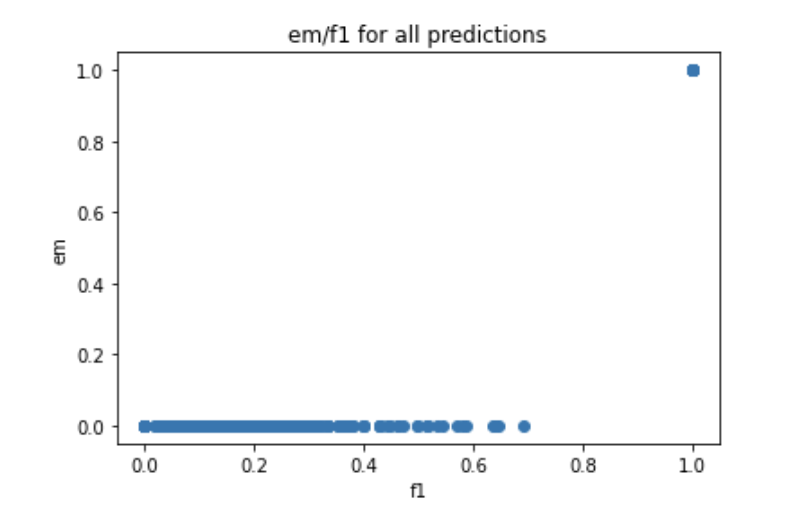

In terms of unanswerability, it yields f1 score of around 50.7% and em score around 36.6%. About 62.0% of all predictions of unanswerablity is false positives, i.e. predicting unanswerable when answer exists. Among questions that have answers, em score is 0 and f1 score is 0.7%. This is mainly because the model predicts all 0s for lots of questions even though class weights are set to 3:7. Also since the model predicts the whole sentence as the answer rather than phrases, there's no exact match and f1 score is low because of the redunant false positives in the predicted answers.



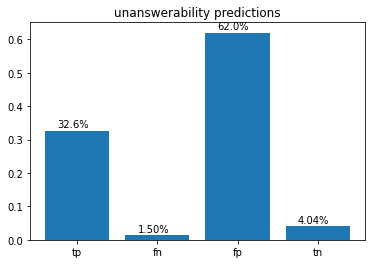

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.title('unanswerability predictions')
x = np.arange(4)
y = [0.3259065765212047, 0.013982790411800861, 0.6196220036877689, 0.040488629379225566]
yy = ['32.6%', '1.50%', '62.0%','4.04%']
plt.bar(x, height=y)
plt.xticks(x, ['tp','fn','fp','tn'])
for (i, v), val in zip(enumerate(yy), y):
    plt.text(x[i] - 0.25, val + 0.01, v)





---


Q3.2: When did the system work well? When did it fail?  Any ideas as to why? How might you improve the system?

**Answer:**

The system yields better results when the answer and question tokens repeatedly occurs in the context. For example,  
```
'answer': ['hong', 'kong', 'polytechnic'], 
'predicted': ['first', 'polytechnic', 'in', 'hong', 'kong', 'is', 'hong', 'kong', 'polytechnic', 'established', 'in', '1972', 'through', 'upgrading', 'hong', 'kong', 'technical', 'college', 'government', 'trade', 'school', 'before', '1947', 'second', 'polytechnic', 'city', 'polytechnic', 'of', 'hong', 'kong', 'was', 'founded', 'in', '1984'], 
'context': [['first', 'polytechnic', 'in', 'hong', 'kong', 'is', 'hong', 'kong', 'polytechnic', 'established', 'in', '1972', 'through', 'upgrading', 'hong', 'kong', 'technical', 'college', 'government', 'trade', 'school', 'before', '1947'], ['second', 'polytechnic', 'city', 'polytechnic', 'of', 'hong', 'kong', 'was', 'founded', 'in', '1984'], ['these', 'polytechnics', 'awards', 'diplomas', 'higher', 'diplomas', 'as', 'well', 'as', 'academic', 'degrees'], ['like', 'united', 'kingdom', 'two', 'polytechnics', 'were', 'granted', 'university', 'status', 'in', '1994', 'and', 'renamed', 'hong', 'kong', 'polytechnic', 'university', 'and', 'city', 'university', 'of', 'hong', 'kong', 'respectively'], ['hong', 'kong', 'university', 'of', 'science', 'and', 'technology', 'university', 'with', 'focus', 'in', 'applied', 'science', 'engineering', 'and', 'business', 'was', 'founded', 'in', '1991']], 
'question': ['what', 'was', 'very', 'first', 'polytechnic', 'school', 'in', 'hong', 'kong']}
```
where 'hong', 'kong', and 'polytechnic' appears multiple times in the context, question and answer. Since we are using the averaged word embeddings and cosine distance from context sentence to question, these overlapping repeated keywords could make it easier for the model to select the answer sentence by looking at the context sentences and the question.

The system mostly fails in terms of em scores. Since we are predicting sentences and most answers are phrases or smaller spans, there is no exact matches, except for predicting no-answers. 

For a similar reason to why the system works well, the system also fails sometimes because the similarity between the question and a sentence in the context tricks it to select that sentence as the answer. For example,
for the question:
```
['when', 'did', 'china', 'first', 'host', 'mens', 'rhythmic', 'gymnastics', 'world', 'championship']
```
the model predicts:
```
['on', 'november', '27–29', '2003', 'japan', 'hosted', 'first', 'edition', 'of', 'mens', 'rhythmic', 'gymnastics', 'world', 'championship']
```
The tokens in the predicted answer highly overlap with those in the question, and 'china' and 'japan' are similar in word embeddings (with cosine distance of 0.7). Thus, the model fails to predict it as unanswerable.


To improve the system, one solution is to further predict the answer span after selecting the correct sentence that contains the answer. This could be achieved by training another logistic regression model but on the sentence containing the span and the question for each context-question pair and label each token with 1 = in span and 0 = out of span. Lining up these two models, we could expect more exact matches and higher precision scores. 


---


Q3.3: What is the effect of the method used for handling unknown words? Note: Even if you choose to skip over unknown words, that is still a _method_ of handling out-of-vocabulary terms.

**Answer:**

When vectorizing the input, we skip over unknown words, i.e. if the word is not in the GloVe dictionary, we don't add it to the vector to be averaged as the sentence embedding. Since we are adding up all word embeddings in a sentence, using such method wouldn't affect the sentence embedding too much, because unknown words are rare and wouldn't be the majority of the tokens in a sentence. By inspecting the unknown words during validation, we observed that most unknown words are numbers (e.g. 2000-3000, £22000), foreign language/pronounciation(e.g. 常用漢字/ˈkætələn), and tokenization inaccuracies(e.g. energyefficiency, endtoend). Ignoring foreign language/pronounciation tokens typically won't bring much inaccuracy because they are usually sidenotes to the english tokens in the context. With more accurate tokenization method, we may reduce the portion of mistokenized words identified as unknown words. Numbers can be tricky, since a monetary value and a year number can be very different in meanings. Ignoring them may also not affect much, since the tokens around them are usually indicative of their meanings (e.g. dollars, year).


# Part B: Fine-tune a Pre-trained Language Model

---

In this part, the goal is to build a strong system by fine-tuning a pre-trained language model. You can use **any** public code, **any** pre-trained language models, and **any** hardware resources -- anything other than code specifically written for SQUAD. A reasonable baseline F1 score to aim for is around 0.7.



### Q4: Implementation Details

Q4.1: Explain here how you implemented the fine-tuning (e.g. which algorithms/data structures you used, what features are included). Make clear which parts were implemented from scratch vs. obtained via an existing package. 


**Answer:**
We used pretrained tokenizer 'distilbert-base-uncased' to tokenize the input into pretrained DistilBertModel 'distilbert-base-uncased'.

We established a training and validation dataset using PyTorch Dataset that gives for each batch a dictionary with keys 'input_ids', 'attention_mask', 'start', and 'end'. 

'Input_ids' and 'attention_mask' are obtained from the tokenizer. 'Input_ids' are tensors of indices of input sequence tokens (question + context) in the vocabulary. 'Attention_mask' contains tensors of 0s for masked and 1s for not masked to avoid performing attention on padding token indices. 

'Start' contains indices of the start token of the answer span in the encoded sequence, and 'end' contains indices of the end token of the answer span. If the question is unanswerable, the start and end indices will both be 0 which is the "[CLF]" token, according to the original BERT paper.

We built a model using nn.Module that takes the last hidden layer of the DistilBertModel, added a linear layer for predicting start token index and another for end token index, and applied softmax to both to get the probability distribution of the start and end token indices. Losses for both vectors are calculated and backpropagated during training using the NLLLoss function on the actual indices.



In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from tqdm.notebook import tqdm, trange

In [ ]:
# Lambda to switch to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
!pip install transformers

In [ ]:
import itertools
import transformers
from transformers import DistilBertTokenizer, DistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
class QAData(Dataset):
    def __init__(self, data):
      '''
      input: data
      List[(List[List[context]],List[question],List[answer])], preprocessed
      '''
      self.X = {}
      for contexts, question, answer in data:
        context = list(itertools.chain.from_iterable(contexts))
        encoding = tokenizer.encode_plus(text=question, text_pair=context, add_special_tokens=True, is_split_into_words=True, padding='max_length', truncation=True)

        #find start and end indices
        start_id, end_id = 0, 0
        inputs = encoding['input_ids']
        # print(inputs)
        tokens = tokenizer.convert_ids_to_tokens(inputs)
        l = len(tokens)
        # print(tokens)
        if answer != []:
          i = 0
          while i<l:
            if tokens[i] == answer[0]:
              if _is_span(tokens, answer, i):
                start_id = i
                end_id = i + len(answer) - 1
                break
            i+=1

        if 'input_ids' in self.X:
          self.X['input_ids'].append(encoding['input_ids'])
          self.X['attention_mask'].append(encoding['attention_mask'])
          self.X['start'].append(start_id)
          self.X['end'].append(end_id)
        else:
          self.X['input_ids'] = [encoding['input_ids']]
          self.X['attention_mask'] = [encoding['attention_mask']]
          self.X['start'] = [start_id]
          self.X['end'] = [end_id]

    def __len__(self):
      '''__len__ returns the number of samples in the dataset.
      :returns: number of samples in dataset
      :rtype: int
      '''
      return len(self.X.input_ids) 

    def __getitem__(self, idx):
      '''
      __getitem__ returns the tensor, output pair for a given index

        :param index: index within dataset to return
        :type index: int
        :returns: a dictionary with keys: input_ids, attention_mask, start, end
        :rtype: dict
      '''
      return {key: torch.tensor(val[idx]) for key, val in self.X.items()}


def get_data_loaders(train, val, batch_size = 32):
  dataset = QAData(train + val) # preprocessed

  train_idx = [i for i in range(len(train))]
  val_idx = [i for i in range(len(train), len(train)+len(val))]

  train_sampler = SubsetRandomSampler(train_idx)
  train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)

  val_sampler = SubsetRandomSampler(val_idx)
  val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

  return train_loader, val_loader



In [ ]:
import transformers
from transformers import DistilBertTokenizer, DistilBertModel
import torch

class Bert(nn.Module):
  def __init__(self, h, output_dim):
    super(Bert, self).__init__()
    self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
    self.start_linear = nn.Linear(h, output_dim)
    self.end_linear = nn.Linear(h, output_dim)
    self.softmax = nn.LogSoftmax(dim=1)
    self.loss = nn.NLLLoss()
  
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids, attention_mask) # input = bert tokenizer encoding
    lhs = outputs.last_hidden_state # (batch_size, sequence_length, hidden_size)
    out = lhs[:, -1, :] # (batch_size, hidden_dim)
    st = self.start_linear(out).to(device)
    end = self.end_linear(out).to(device)
    # print(st)
    predict_start = self.softmax(st).to(device)
    predict_end = self.softmax(end).to(device)

    return predict_start, predict_end

  def compute_loss(self, predicted_vector, gold_label):
    return self.loss(predicted_vector, gold_label)
  
  def load(self, path):
    self.load_state_dict(torch.load(path))

  def save(self, path):
    torch.save(self.state_dict(), path)

def train_epoch(model, train_loader, optimizer):
  model.train()
  total = 0
  st_loss, st_correct, st_total_loss = 0, 0, 0
  end_loss, end_correct, end_total_loss = 0, 0, 0

  for batch in train_loader:
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_idx = batch['start'].to(device)
    end_idx = batch['end'].to(device)

    start, end = model(input_ids=input_ids, attention_mask=attention_mask)

    # compute the prediction loss
    # print("pred", start)
    # print("actual", start_idx)
    _, predicted_st_idx = torch.max(start, 1)
    _, predicted_end_idx = torch.max(end, 1)
    # print("pred idx", predicted_st_idx, predicted_end_idx)
    st_loss = model.compute_loss(start, start_idx)
    end_loss = model.compute_loss(end, end_idx)
    st_total_loss += st_loss.item()
    end_total_loss += end_loss.item()
    
    # perform backward propagation to compute the gradients
    loss = st_loss + end_loss
    loss.backward()

    # update the weights
    optimizer.step()  

  print('train loss',st_total_loss/len(train_loader),end_total_loss/len(train_loader))
  return

In [ ]:
def train_and_eval(number_of_epochs, model, train_loader, val_loader, save_file_name = None):
  optimizer = AdamW(model.parameters(), lr=1e-5)
  for i in range(number_of_epochs):
    print('Epoch', i+1)
    train_epoch(model, train_loader, optimizer)
    model.save(save_file_name)
  return

In [ ]:
# from transformers import AdamW
train_loader, val_loader = get_data_loaders(p_train, p_val, batch_size=16)

In [ ]:
# import pickle
# # save the loaders
# with open('train_loader16.pkl', 'wb') as fid:
#     pickle.dump(train_loader, fid)    
# with open('val_loader16.pkl', 'wb') as fid:
#     pickle.dump(val_loader, fid)    

In [ ]:
# import pickle
# load it again
# with open('train_loader16.pkl', 'rb') as fid:
#     train_loader = pickle.load(fid)
# with open('val_loader16.pkl', 'rb') as fid:
#     val_loader = pickle.load(fid)

In [ ]:
from transformers import AdamW
model = Bert(768, 768).to(device)
train_and_eval(3, model, train_loader, val_loader, 'test.pth')

Epoch 1
train loss 2.7819337725233315 2.7855084100925955
Epoch 2
train loss 2.3662598772862626 2.3731504838944133
Epoch 3
train loss 2.038577475382538 2.050012748915834


In [ ]:
# model = Bert(768, 768).to(device)
# model.load('/content/test (2).pth')

In [ ]:
def evaluation(model, val_loader, optimizer=None):
  results = []
  model.eval()
  total = 0
  st_loss, st_correct, st_total_loss = 0, 0, 0
  end_loss, end_correct, end_total_loss = 0, 0, 0 
  k = 0

  with torch.no_grad():
    for batch in val_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      start_idx = batch['start'].to(device)
      end_idx = batch['end'].to(device)
      # print(start_idx, end_idx)
      start, end = model(input_ids=input_ids, attention_mask=attention_mask)

      for gold_st, gold_end, pred_start, pred_end, input in zip(start_idx, end_idx, start, end, input_ids):
        # print(gold_st, gold_end) # int, int
        # print(pred_start, pred_end) # 1d tensors

        # ======== Reconstruct Answer ========
        # Find the tokens with the highest `start` and `end` scores.
        answer_start, answer_end = find_score(pred_start, pred_end)

        # Get the string versions of the input tokens.
        tokens = tokenizer.convert_ids_to_tokens(input)

        predicted = construct(answer_start, answer_end, tokens)
        gold = construct(gold_st, gold_end, tokens)
        # print(predicted, gold)
        f1 = compute_f1(gold,predicted)
        exact = compute_exact(gold,predicted)
        results.append({'f1': f1, 'exact': exact, 'answer': gold, 'predicted': predicted, 'input':tokens, 'answerable': predicted != '[CLS]' and  predicted != '[SEP]' and  predicted != '[PAD]'})

  return results

def find_score(start, end):
  max = float('-inf')
  st_id, end_id = 0, 0
  for i in range(len(start)):
    j = i
    while j <len(end):
      sum = start[i] + end[j]
      if sum>max:
        st_id = i
        end_id = j
        max = sum
      j+=1
  return st_id, end_id

def construct(start, end, tokens):
  # Start with the first token.
  answer = [tokens[start]]

  # Select the remaining answer tokens and join them with whitespace.
  for i in range(start + 1, end + 1):
      
    # If it's a subword token, then recombine it with the previous token.
    if tokens[i][0:2] == '##':
        answer.append(tokens[i][2:]) 
    
    # Otherwise, add a space then the token.
    elif tokens[i] != '[CLS]' and  tokens[i] != '[SEP]' and tokens[i] != '[PAD]':
        answer.append(tokens[i])
  return answer


In [ ]:
results = evaluation(model, val_loader)

In [ ]:
# genearl f1/em
f1, em = 0,0
for r in results:
  f1 += r['f1']
  em += r['exact']
print('em:', em/len(results))
print('f1:', f1/len(results))

em: 0.6053921568627451
f1: 0.6250196766740884


In [ ]:
# has ans
f1, em = 0,0
total = 0
for r in results:
  total+=1
  if r['answer'] != ['[CLS]']:
    f1 += r['f1']
    em += r['exact']
print('em:', em/total)
print('f1:', f1/total)

em: 0.003676470588235294
f1: 0.02330399039957863


In [ ]:
# unanswerability
tp, tn, fp, fn =0, 0, 0, 0
for r in results:
  if r['answer'] == ['[CLS]'] and r['predicted'] == ['[CLS]']:
    tp += 1
  elif r['answer'] != ['[CLS]'] and r['predicted'] == ['[CLS]']:
    fp += 1
  elif r['answer'] == ['[CLS]'] and r['predicted'] != ['[CLS]']:
    fn += 1
  else:
    tn += 1
  
em = (tp+tn) / (tp+fn+fp+tn)
f1 = tp/(tp+1/2*(fn+fp))
print('em: ', em)
print('f1: ', f1)
sum = tp+fn+fp+tn
print(tp/sum, fn/sum, fp/sum, tn/sum)

em:  0.6678921568627451
f1:  0.7837190742218675
0.6017156862745098 0.0024509803921568627 0.32965686274509803 0.0661764705882353


### Q5: Results Analysis

Q5.1: Explain here how you evaluated the model. Summarize the performance of your system and any variations that you experimented with the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis. 

**Answer:**

In evaluation, we picked the start and end indices that have the highest probability in total to be the predicted start and end indices. Then we used these indices to reconstruct the answers in tokens, and evaluated the f1 and em scores in general, among unanswerable and answerable questions respectively. If the reconstructed answer is '[CLS]', the question is unanswerable.

In general, the model reaches em score of 60.5% and f1 score of 62.5% on the validation set. As we can tell from the graph, the f1 score of individual predictions range from 0 to almost 0.9 for non-exact matches. The exact matches in the right upper corner consist of both correctly predicted unanswerable questions and correctly predicted spans.




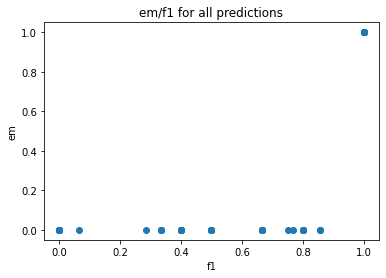

In [ ]:
import matplotlib.pyplot as plt
em = []
f1 = []
for r in results:
  em.append(r['exact'])
  f1.append(r['f1'])
plt.title('em/f1 for all predictions')
plt.xlabel('f1')
plt.ylabel('em')
plt.scatter(f1, em)
plt.show()

In terms of predicting unanswerablity, it yields em score of 66.8% and f1 score of 78.4%. About 60.2% of the predicted unanswerabilty are correct (true positives), 33.0% are false positives, i.e. predicting unanswerable when answer exits. Only a small portion of 0.25% is predicting answer when there isn't one and 6.62% is correctly predicting an answer when there is one. This is because the model is mostly predicting questions to be unanswerable except around 6.9% of all predictions.



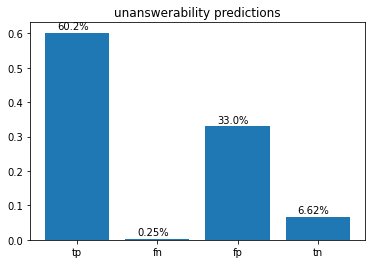

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.title('unanswerability predictions')
x = np.arange(4)
y = [0.6017156862745098, 0.0024509803921568627, 0.32965686274509803, 0.0661764705882353]
yy = ['60.2%', '0.25%', '33.0%','6.62%']
plt.bar(x, height=y)
plt.xticks(x, ['tp','fn','fp','tn'])
for (i, v), val in zip(enumerate(yy), y):
    plt.text(x[i] - 0.25, val + 0.01, v)

Among answerable questions, the model yields em score of 0.36% and f1 score of 2.33%. Since this model is predicting spans rather than the whole sentences, there are several exact matches, and f1 is higher since the precision is higher.


---





Q5.3: When did the system work well, when did it fail and any ideas as to why? How might you improve the system?

**Answer:**
The model works well when the question structure is similar to the structure in the context where the answer is to be exacted. For example,
```
answer': ['ljubljana'], 'predicted': ['ljubljana']
```
```
'question': 'where', 'was', 'street', 'named', 'after', 'tito', 'that', 'was', 'found', 'unconstitutional', 'located'
```
```
'context': ...'found', '2009', 'naming', 'of', 'street', 'in', 'ljubljana', 'after', 'tito', 'to', 'be', 'unconstitutional'...
```
where the sentence structure is similar and there are overlapping of lots of tokens between the question and the context around the answer. This may lead to high probability generated around the answer, making the predicted indices more accurate.

It also performs well in predicting times and numbers. A large portion of predictions with high f1 scores are those predicting dates, years, or counts, for example,

```
'answer': ['1792'], 'predicted': ['1792', 'as']
```
```
'answer': ['53'], 'predicted': ['53', 'buses']
```
This is possibly because questions for numbers have less variation, i.e. are mostly "in what year", "how many", etc. Thus, these questions will have a strong indication of the answer being numerical.

The model fails at predicting too many questions as unanswerable, probability due to lower complexity of the layers for index prediction and less epochs of training. 

It also fails by predicting longer span than needed or predicting span that partially overlaps with the gold labels. For example,
```
'answer': ['shipbuilding'], 'predicted': ['shipbuilding', 'became']
```
```
'answer': ['thomas', 'edward', 'gordon'], 'predicted': ['gordon', 'published']
```
This is possibly because the probabilities around the actual start/end indices are similiar. Especially for shorter spans, since we pick the indices by the largest sum of probabilities, the sum can be similar around the actual span and the correct span may not necessarily have strictly the largest sum. Thus, the model could pick a span that's slightly off.


I would improve the system by:
1. training for more epochs. The model is trained for 3 epochs with consistant decrease in loss (start_index_loss: 2.78 -> 2.04; end_index_loss: 2.79 ->2.05). If it is trained longer till we observe a constant or increasing loss, the model may fit to the dataset better and yield better predictions.

2. adding more layers. The model has only one linear layer from the output of DistilBert to the prediction vector. We could add more layers to it to increase complexity so that it might perform better.

3. incorporating Self-Supervised Attention (SSA) (Kou, et al., 2020) to automatically generate weak, token-level attention labels iteratively by "probing" the fine-tuned model from the previous iteration, which was shown in the paper to greatly improve the model performance.


#Comparing the two models

---


### Q6:


Compare here your results for the two models. How are you evaluating their performance? Which of them performs better using this metric and how much better? 

**Answer:**

For both models, I used em and f1 scores for evaluating all predictions and predictions for unanswerable questions and for answerable questions.

Model 2 performs better using this metric. Over all predictions, model 2 is 27.4% (60.5% vs 33.1%) higher in em score and 29.9% (62.5% vs 32.6%) higher in f1 score. 

In terms of unanswerability, model 2 is 30.2% better (66.8% vs 36.6%) in em score and 27.7% better in f1 score (78.4% vs 50.7%) compared to model 1. Model 2 also significantly decreases in false positives (predicting answerable questions as unanswerable) by 29% (33.0% vs 62.0%) and increases in true negatives (correctly predicting that there is an answer) by 2.58% (6.62% vs 4.04%) since in general model 2 is predicting more answers than model 1.

Among all answerable questions, model 2 has also higher em and f1 scores by 0.36% (0.36% vs 0%) and 1.63% (2.33% vs 0.7%) higher than model 1. Most obviously, model 2 has exact matches because it predicts in smaller spans rather than sentence spans.



---




###Q7: Error Analysis
Do some error analysis. What are error patterns you observed one model making but not the other? Try to justify why/why not?

**Answer:**

Lots of errors in model 1 is due to redundant tokens in the correctly picked sentence. For example,
```
'answer': ['hong', 'kong', 'polytechnic'], 
'predicted': ['first', 'polytechnic', 'in', 'hong', 'kong', 'is', 'hong', 'kong', 'polytechnic', 'established', 'in', '1972', 'through', 'upgrading', 'hong', 'kong', 'technical', 'college', 'government', 'trade', 'school', 'before', '1947', 'second', 'polytechnic', 'city', 'polytechnic', 'of', 'hong', 'kong', 'was', 'founded', 'in', '1984']
```
This is not observed in model 2. The predicted span in model 2 is much smaller, although it can also predict larger spans than necessary, for example,
```
'answer': ['17th', 'century'], 'predicted': ['france', 'in', '17th', 'century']
```
This is because model 1 predicts on spans of sentences, while model 2 predicts smaller spans. 

In the cases where the models predict an answer when the question is unanswerable, model 1 typically makes such error when the extracted sentence structure is highly similar to the question. For example,
```
question: ['who', 'built', 'early', 'mandolin', 'in', '1795']
predicted: ['earliest', 'extant', 'mandolin', 'was', 'built', 'in', '1744', 'by', 'antonios', 'son', 'gaetano', 'vinaccia']
```
where everything else is the same except the question is asking about 1795 and the context is about 1744. This pattern is not observed in model 2, because model 1 takes the sentence embedding and its cosine distance to the question embedding as input instead of a token level embedding. Thus, the high similarity between the context and question sentences leads model 1 to predict this sentence as the answer, ignoring the difference on a single token.



# Gradescope Submission 
---




This time, we will actually be probing your model rather than you having to predict on the test set. We show an example in the appendix but you will need to upload a zip file that contains `solution.py`. This file will download your parameters via Google drive, load them into your model, and have a `predict` function that we will use.

The `predict` function takes in a `question` string and an `context` string identifies the words within the `context` that are the answer (if there is one) and also returns the answerability of the question. We give a sample within the appendix

### Q9: Competition Score
Include here your **team name** and the **screenshot** of your best score from Gradescope.

**Answer:** aj592

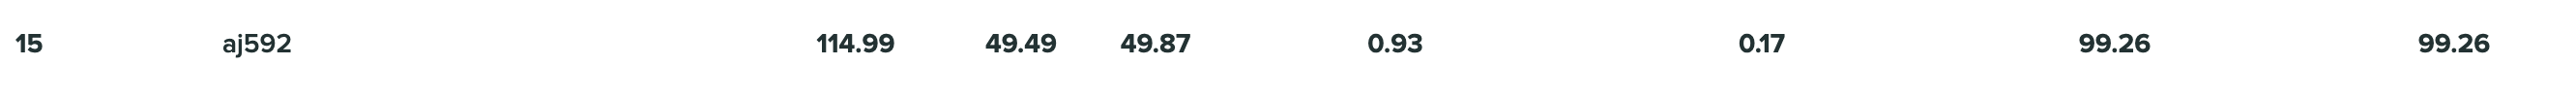

#Appendix
---


## Approximate Projected Point Breakdown

- Q1. Dataset observations (5)
- Q1.1 Implement and discuss the metric(s) (5)
- Q2. Implement your own model (20)
- Q3. Evaluate your own model (10)
- Q4. Implement finetuning (25)
- Q5. Evaluate finetuned model (10)
- Q6. Compare the results (5)
- Q7. Failure analysis (5)
- Q8. Predictions submission (5)
- Code quality (5)
- Page assignment and clarity (5)







## Gradescope Details

Below is a sample `solution.py` code to submit on gradescope. This is also available on Piazza! As it stands, it will not run but this is because the QA model is currently not defined. This is something you will need to write.

```python
import os
import pathlib
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import re

import requests
import torch
import transformers

directory = pathlib.Path(__file__).parent.absolute()

drive_path = "https://drive.google.com/file/d/1NbdW7rPuuCd6ij4bR_2yLL8zGvqfyVIb/view?usp=sharing"

gdrive_id = re.search("https://drive.google.com/file/d/(.*)/view\?usp=sharing", drive_path).group(1)
# print(f"GDrive ID: {gdrive_id}")

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


download_file_from_google_drive(gdrive_id, f"{str(directory / 'netid_parameters.zip')}")
print("Parameters downloaded")

proc = subprocess.Popen([f"unzip -o {str(directory / 'netid_parameters.zip')} -d {str(directory)}"], stdout = subprocess.PIPE, shell=True)

(out, error) = proc.communicate()
pathlib.Path(f"{str(directory / 'netid_parameters.zip')}").unlink()
pathlib.Path(f"{str(directory / 'netid_parameters')}").unlink()


get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"
model = BertQAModel.from_pretrained(str(directory / "netid_parameters" / "model")).to(get_device())
tokenizer = BertTokenizer.from_pretrained(str(directory / "netid_parameters" / "tokenizer"))

model.eval()
print("Model loaded")


def predict(question, context):
    '''predict uses your PCE model and predicts the answer and answerability

    Takes a `question` string and an `context` string (which contains the
    answer), and identifies the words within the `context` that are the
    answer, and if there is an answer

    :param question: The question to answer
    :type question: str
    :param context: The context in which to search for the answer
    :type context: str
    :return: A pair of (answer, hasAns) that represents the model's prediction
        on the answer and whether this question is answerable
    :rtype: Tuple[str, bool]
    '''
    with torch.no_grad():
        # ======== Tokenize ========
        # Apply the tokenizer to the input text, treating them as a text-pair.
        input_ids = tokenizer.encode(question, context, max_length=512, truncation=True,)

        # Report how long the input sequence is.
        # print('Query has {:,} tokens.\n'.format(len(input_ids)))

        # ======== Set Segment IDs ========
        # Search the input_ids for the first instance of the `[SEP]` token.
        sep_index = input_ids.index(tokenizer.sep_token_id)

        # The number of segment A tokens includes the [SEP] token istelf.
        num_seg_a = sep_index + 1

        # The remainder are segment B.
        num_seg_b = len(input_ids) - num_seg_a

        # Construct the list of 0s and 1s.
        segment_ids = [0]*num_seg_a + [1]*num_seg_b

        # There should be a segment_id for every input token.
        assert len(segment_ids) == len(input_ids)

        # ======== Evaluate ========
        # Run our example question through the model.
        start_scores, end_scores = model(torch.tensor([input_ids]).to(get_device()), # The tokens representing our input text.
                                        token_type_ids=torch.tensor([segment_ids]).to(get_device())) # The segment IDs to differentiate question from context

        # ======== Reconstruct Answer ========
        # Find the tokens with the highest `start` and `end` scores.
        answer_start = torch.argmax(start_scores.cpu())
        answer_end = torch.argmax(end_scores.cpu())

        # Get the string versions of the input tokens.
        tokens = tokenizer.convert_ids_to_tokens(input_ids)

        # Start with the first token.
        answer = tokens[answer_start]

        # Select the remaining answer tokens and join them with whitespace.
        for i in range(answer_start + 1, answer_end + 1):
            
            # If it's a subword token, then recombine it with the previous token.
            if tokens[i][0:2] == '##':
                answer += tokens[i][2:]
            
            # Otherwise, add a space then the token.
            else:
                answer += ' ' + tokens[i]

        # print('Answer: "' + answer + '"')

        return answer, True

```
